Primero importamos las librerías que vamos a necesitar para nuestro modelo de regresión logística

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

Ahora introducimos la ruta en la que están ubicados los archivos con la información que se analizará y tambíen aprovechamos para hacer un pequeño ajuste en la visualización del dataframe para meyor versatilidad.

In [25]:
train = pd.read_csv('/home/luis-loreto/Documentos/Proyectos/Titanic/Titanic/Datos/train.csv')
test = pd.read_csv('/home/luis-loreto/Documentos/Proyectos/Titanic/Titanic/Datos/test.csv')

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [26]:
train_c, validacion = train_test_split(train, test_size=0.2, random_state=42)

Iniciamos con el análisis exploratorio. Vemos cuántos registros tiene cada variable. Se puede observar que son 11 variables independientes y una dependiente: Survived. Ésta última será la variable para el aprendizaje en nuestro modelos de machine learning. 

In [6]:
Variables = {
    "Observaciones" : train_c.count(),
    "Missings": train_c.isnull().sum()
}
pd.DataFrame(Variables)

,Observaciones,Missings
PassengerId,712,0
Survived,712,0
Pclass,712,0
Name,712,0
Sex,712,0
Age,572,140
SibSp,712,0
Parch,712,0
Ticket,712,0
Fare,712,0


Vemos que las variables con missings son: Age, Cabin y Embarked. Debemos decidir si vamos a utilizar dichas variables y en su caso qué método de imputación elegir. Por el momento, descartaremos la variable Cabin, pues sus missings representan más de la mitad de las observaciones del dataframe. Usaremos algún método de imputación en las variables Age y Embarked para poder incluirlas en el modelo.

Ahora iniciaremos con la imputación para las variables Age y Embarked. Vamos a crear una función que le asigne valores aleatorios de su determinada variable a las observaciones con valores faltantes-

In [27]:
def hotdeck_imputation(data: pd.DataFrame, variable: str) -> pd.DataFrame:
    """
    Realiza una imputación hot-deck aleatoria en una columna específica de un DataFrame.

    Para cada valor faltante en la columna, lo reemplaza con un valor
    seleccionado aleatoriamente de los valores no faltantes en esa misma columna.

    Args:
        data (pd.DataFrame): El DataFrame que contiene los datos.
        variable (str): El nombre de la columna en la que se imputarán los valores.

    Returns:
        pd.DataFrame: El DataFrame con la columna especificada ya imputada.
    """
    # Copia para evitar la advertencia SettingWithCopyWarning
    target_col = data[variable]

    # 1. Encontrar los índices de los valores faltantes
    missing_indices = target_col[target_col.isnull()].index

    # 2. Obtener los valores no faltantes de donde se tomará la muestra
    non_missing_values = target_col.dropna()

    # 3. Generar muestras aleatorias para cada valor faltante
    # Se usa replace=True por si el número de faltantes es mayor que el de existentes
    random_samples = np.random.choice(non_missing_values, size=len(missing_indices), replace=True)

    # 4. Asignar las muestras a los índices faltantes en una sola operación
    data.loc[missing_indices, variable] = random_samples

    return data


In [28]:
train_c = hotdeck_imputation(train_c, "Age")
train_c = hotdeck_imputation(train_c, "Embarked")

In [20]:
Variables = {
    "Observaciones" : train_c.count(),
    "Missings": train_c.isnull().sum()
}
pd.DataFrame(Variables)

,Observaciones,Missings
PassengerId,712,0
Survived,712,0
Pclass,712,0
Name,712,0
Sex,712,0
Age,712,0
SibSp,712,0
Parch,712,0
Ticket,712,0
Fare,712,0


Ahora vamos a corroborar que nuestro dataframe no tenga valores faltantes.

Ahora iniciaremos con el proceso de One Hot Encoding. Crearemos variables dummies para aquellas con observaciones categóricas, es decir, para Sex, Pclass y Embarked

In [29]:
train_c = pd.get_dummies(train_c, columns = ['Sex', 'Pclass', 'Embarked'], drop_first=True, dtype=float)

Ahora creamos un conjunto de las variables independientes que usaremos y que ya pasaron por un proceso de one hot encoding y otro para la variable dependiente

In [30]:
X_train_c = train_c[["Age", "SibSp", "Parch", "Fare", "Sex_male", "Pclass_2", "Pclass_3", "Embarked_Q", "Embarked_S"]]
y_train_c = train_c[["Survived"]]

Independientemente del modelo que vayamos a usar, debemos darle el mismo tratamiento al conjunto de tratamiento. Primero identificaremos si tiene valores faltantes:

Vemos que sí, entonces ahora le aplicamos la función que creamos para la imputación. En este caso, se usará para las variables Fare y Age. Cabin se descarta porque los valores faltantes correspondonde a más de la mitad del total.

In [31]:
validacion = hotdeck_imputation(validacion, "Age")
validacion = hotdeck_imputation(validacion, "Fare")
validacion = pd.get_dummies(validacion, columns = ['Sex', 'Pclass', 'Embarked'], drop_first=True, dtype=float)
X_val = validacion[["Age", "SibSp", "Parch", "Fare", "Sex_male", "Pclass_2", "Pclass_3", "Embarked_Q", "Embarked_S"]]
y_val = validacion[["Survived"]]
y_train_r = train_c["Survived"].values.ravel()  #  ¡Aquí está el cambio!

Ahora crearemos nuestro conjunto para la variable dependiente y para la variable independiente, que se encuentra en otro archivo llamado "gender_submission"

Ahora aplicamos el one hot encodging

Ahora vamos a guardar los archivos ya preparados en nuestra carpeta "Datos"

## Bosque aleatorio

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

# Definir el modelo RandomForestClassifier
model = RandomForestClassifier()

# Definir los parámetros para el GridSearch
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Configurar el GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Ajustar el GridSearchCV a los datos
grid_search.fit(X_train_c, y_train_r)

# Obtener los mejores parámetros y el mejor puntaje
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Mejores parámetros: {best_params}")
print(f"Mejor puntaje: {best_score}")

Mejores parámetros: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Mejor puntaje: 0.8272431793558553


In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
import numpy as np

# Definir diferentes configuraciones de Random Forest
models = {
    'Random Forest GridSearch': RandomForestClassifier(
        max_depth = grid_search.best_params_['max_depth'], 
        min_samples_leaf = grid_search.best_params_['min_samples_leaf'], 
        min_samples_split = grid_search.best_params_['min_samples_split'], 
        n_estimators = grid_search.best_params_['n_estimators']),
}

kf = KFold(n_splits=30)  # Aquí usamos 30 folds

results = {}

for model_name, model in models.items():
    scores = cross_val_score(model, X_train_c, y_train_r, cv=kf, scoring='accuracy')
    results[model_name] = scores
    print(f'{model_name}: Mean accuracy = {np.mean(scores)}, Std = {np.std(scores)}')

Random Forest GridSearch: Mean accuracy = 0.8204106280193237, Std = 0.08842699582168771


In [40]:
for model_name, model in models.items():
    scores = cross_val_score(model, X_val, y_val_r, cv=kf, scoring='accuracy')
    results[model_name] = scores
    print(f'{model_name}: Mean accuracy = {np.mean(scores)}, Std = {np.std(scores)}')

Random Forest GridSearch: Mean accuracy = 0.8033333333333333, Std = 0.17476968971891108


In [60]:
import seaborn as sns

# Definir el modelo cuadrático
model = RandomForestClassifier(
        max_depth = grid_search.best_params_['max_depth'], 
        min_samples_leaf = grid_search.best_params_['min_samples_leaf'], 
        min_samples_split = grid_search.best_params_['min_samples_split'], 
        n_estimators = grid_search.best_params_['n_estimators'])

# Entrenar el modelo con el conjunto de entrenamiento completo
model.fit(X_train_c, y_train_r)

RandomForestClassifier(max_depth=5, min_samples_split=5)

In [69]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val_r, y_pred)

Accuracy on test set: 0.7988826815642458


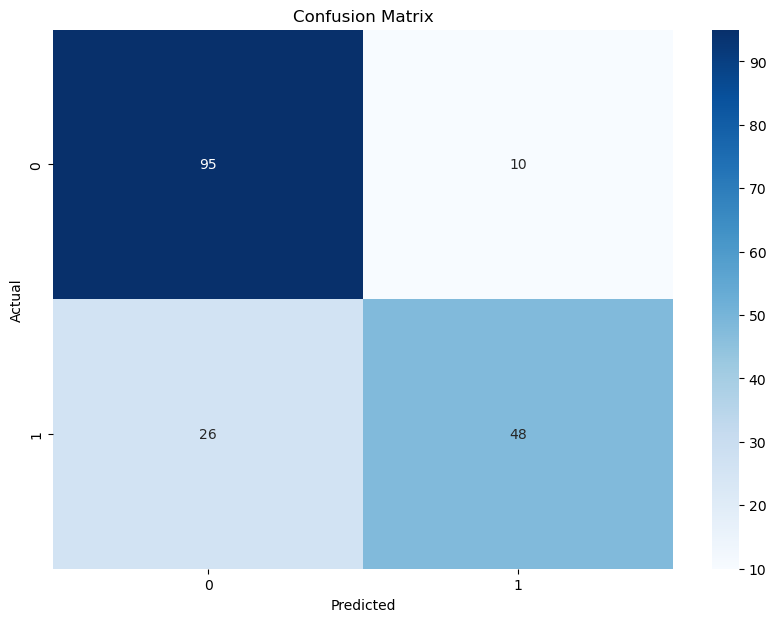

In [70]:
print(f'Accuracy on test set: {accuracy}')

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_val_r, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [73]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Calcular métricas
accuracy = accuracy_score(y_val_r, y_pred)
precision = precision_score(y_val_r, y_pred)
recall = recall_score(y_val_r, y_pred)
f1 = f1_score(y_val_r, y_pred)
roc_auc = roc_auc_score(y_val_r, y_pred)

# Mostrar resultados
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"ROC-AUC: {roc_auc}")

# Mostrar matriz de confusión y reporte de clasificación
print(confusion_matrix(y_val_r, y_pred))
print(classification_report(y_val_r, y_pred))

Accuracy: 0.7988826815642458
Precision: 0.8275862068965517
Recall: 0.6486486486486487
F1-Score: 0.7272727272727273
ROC-AUC: 0.7767052767052768
[[95 10]
 [26 48]]
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       105
           1       0.83      0.65      0.73        74

    accuracy                           0.80       179
   macro avg       0.81      0.78      0.78       179
weighted avg       0.80      0.80      0.79       179



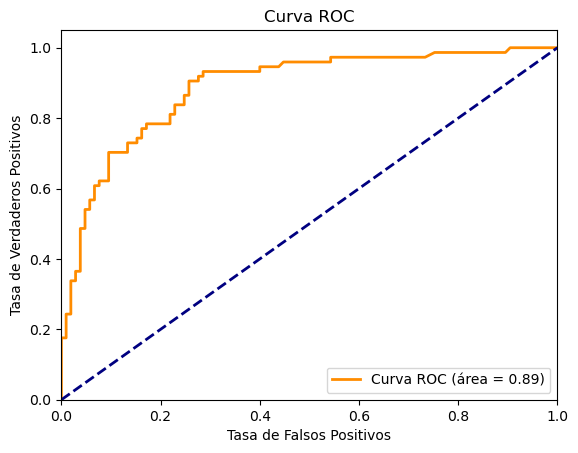

In [76]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_val_r, y_pred)
roc_auc = auc(fpr, tpr)

Y_pred_prob = model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val_r, Y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()